/var/folders/h_/mft4g8yj4p5b9mc1x71fgd680000gn/T/ipykernel_68482/2478415948.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grad_g_lambda[s,:] = np.array([1,epsilon/(2*np.sqrt(sigma2_mu))]).reshape(1,2)
/var/folders/h_/mft4g8yj4p5b9mc1x71fgd680000gn/T/ipykernel_68482/2478415948.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grad_g_lambda[s,:] = np.array([1,epsilon/(2*np.sqrt(sigma2_mu))]).reshape(1,2)


run FFVB RP trick:  0:00:00.160778
lambdaq: [[9.61500683 0.10579865]]
Iterations:  137
Maximum Evidence Lower Bound AVE:  -32.20340345128761


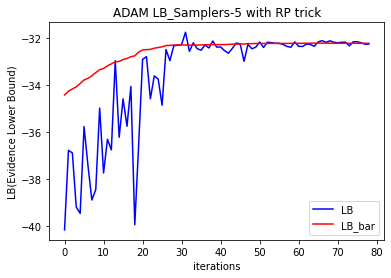

In [203]:
#Algorithm6 Gradient Ascent(ADAM) Reparameterization Trick FFVB
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.special import psi
import math
from datetime import datetime
start=datetime.now()

y = [11, 12, 8, 10, 9, 8, 9, 10, 13, 7] # data
n = len(y)
#===========================
d = 2
S = 5 #number of Monte Carlo samples
beta1_adap_weight = 0.9 # adaptive learning weight
beta2_adap_weight = 0.9 # adaptive learning weight
eps0 = 0.05
   
max_iter = 2000
patience_max = 20
tau_threshold = max_iter/2
t_w = 50

#hyperparameter
#initial model p(mu)~N(mu_hp,sigma2_hp)
mu_hp = 0
sigma2_hp = 10

lambdaq = np.array([np.mean(y),1.5]).reshape(1,2)# initial q(lambda)~N(mu_mu,sigma2_mu)
lambda_best = lambdaq
#print("lambda_best: ",lambda_best)

#function h_lambda_fun
def h_lambda_fun(y,mu_hp,sigma2_hp,mu_mu,sigma2_mu,epsilon):
    log_p_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_hp)-(mu_mu+np.sqrt(sigma2_mu)*epsilon-mu_hp)**2/2/sigma2_hp
    log_q_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_mu)-epsilon**2/2
    llh = -n/2*np.log(2*np.pi)-(1/2)*sum((y-mu_mu-np.sqrt(sigma2_mu)*epsilon)**2)
    return log_p_mu+llh-log_q_mu

mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]

grad_g_lambda = np.zeros((S,d))
grad_h_lambda = np.zeros((S,1))#  function grad_h_lambda
h_lambda = np.zeros((S,1))
grad_g_times_h = np.zeros((S,d))
for s in range(S):
    epsilon = np.random.normal(0,1,1)
    grad_g_lambda[s,:] = np.array([1,epsilon/(2*np.sqrt(sigma2_mu))]).reshape(1,2)
    grad_h_lambda[s] = -(mu_mu+np.sqrt(sigma2_mu)*epsilon-mu_hp)/sigma2_hp + sum(y - (mu_mu+np.sqrt(sigma2_mu)*epsilon))+ epsilon/np.sqrt(sigma2_mu)
    h_lambda[s] = h_lambda_fun(y,mu_hp,sigma2_hp,mu_mu,sigma2_mu,epsilon)    
    grad_g_times_h[s,:] = grad_g_lambda[s,:] * grad_h_lambda[s]

grad_LB1= np.mean(grad_g_times_h[:,0])
grad_LB2= np.mean(grad_g_times_h[:,1])
grad_LB =np.array([grad_LB1,grad_LB2])
#ADAM
g_adaptive = grad_LB
v_adaptive = g_adaptive**2
g_bar_adaptive = g_adaptive
v_bar_adaptive = v_adaptive

iter_ = 1
stop = False
LB = np.array([-1e3 for i in range(2000)])
LB_bar = np.array([-1e3 for i in range(2000)])
patience = 0  
while not stop:
    mu_mu = lambdaq[0,0]
    sigma2_mu = lambdaq[0,1]
    grad_g_lambda = np.zeros((S,d))
    grad_h_lambda = np.zeros((S,1))#  function grad_h_lambda
    h_lambda = np.zeros((S,1))
    grad_log_q_lambda = np.zeros((S,d))
    grad_log_q_times_h = np.zeros((S,d))
    for s in range(S):
        epsilon = np.random.normal(0,1,1)
        grad_g_lambda[s,:] = np.array([1,epsilon/(2*np.sqrt(sigma2_mu))]).reshape(1,2)
        grad_h_lambda[s] = -(mu_mu+np.sqrt(sigma2_mu)*epsilon-mu_hp)/sigma2_hp + sum(y - (mu_mu+np.sqrt(sigma2_mu)*epsilon))+ epsilon/np.sqrt(sigma2_mu)
        h_lambda[s] = h_lambda_fun(y,mu_hp,sigma2_hp,mu_mu,sigma2_mu,epsilon)    
        grad_g_times_h[s,:] = grad_g_lambda[s,:] * grad_h_lambda[s]
    grad_LB1= np.mean(grad_g_times_h[:,0])
    grad_LB2= np.mean(grad_g_times_h[:,1])
    grad_LB =np.array([grad_LB1,grad_LB2]).reshape(1,2)
    g_adaptive = grad_LB
    v_adaptive = g_adaptive**2
    g_bar_adaptive = beta1_adap_weight*g_bar_adaptive+(1-beta1_adap_weight)*g_adaptive
    v_bar_adaptive = beta2_adap_weight*v_bar_adaptive+(1-beta2_adap_weight)*v_adaptive

    if iter_>=tau_threshold:
        stepsize = eps0*tau_threshold/iter_
    else:
        stepsize = eps0

    lambdaq = lambdaq+stepsize*g_bar_adaptive/np.sqrt(v_bar_adaptive)

    LB[iter_] = np.mean(h_lambda)

    if iter_>=t_w:
        LB_bar[iter_-t_w+1] = np.mean(LB[iter_-t_w+1:iter_])

    if iter_>t_w:
        if LB_bar[iter_-t_w+1]>=max(LB_bar):
            lambda_best = lambdaq
            patience = 0
        else:
            patience = patience+1

    if patience>patience_max or iter_>max_iter:
        stop = True
    iter_ = iter_+1

lambdaq = lambda_best
mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
print("run FFVB RP trick: ", datetime.now()-start)
print("lambdaq:",lambdaq)
print("Iterations: ",iter_)
#print("Evidence Lower Bound: ",LB[1:30])
print("Maximum Evidence Lower Bound AVE: ",max(LB_bar))
plt.plot(LB[1:80], color="b",label="LB")
plt.plot(LB_bar[1:80], color="r",label="LB_bar")
plt.title("ADAM LB_Samplers-5 with RP trick") 
plt.xlabel("iterations"); plt.ylabel('LB(Evidence Lower Bound)')
plt.legend()
plt.show()